# 集成学习

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## 学习集成学习

In [9]:
# 用python实现概率密度函数
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier-k) for k in range(k_start, n_classifier+1)]
    return sum(probs)


print(ensemble_error(n_classifier=11, error=0.25))


0.03432750701904297


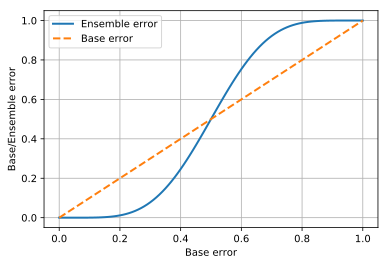

In [10]:
# 计算在error在0到1之间变化时,集成错误的变化,并绘图
import matplotlib.pyplot as plt
import numpy as np
error_range = np.arange(0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_error, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()

## 实现一个简单的多数投票的分类器

$$
\hat{y}=\arg \max _{i} \sum_{j=1}^{m} w_{j} \chi_{A}\left(C_{j}(\boldsymbol{x})=i\right)
$$

In [15]:
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))


1

$$
\hat{y}=\arg \max _{i} \sum_{j=1}^{m} w_{j} p_{i j}
$$

In [17]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p


array([0.58, 0.42])

In [18]:
np.argmax(p)

0

用python实现MajorityVoteClassifier

In [ ]:
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

